In [42]:

# Quick import + checks
required = ["pandas","numpy"]
import importlib, sys
missing = [p for p in required if importlib.util.find_spec(p) is None]
if missing:
    print("Missing packages:", missing)
    print("Install in notebook: %pip install " + " ".join(missing) + " (or run in terminal)")
    raise SystemExit("Install missing packages and re-run")

import pandas as pd, numpy as np

# robust file lookup (try data_path if present, common variants, and a glob search)
import os, glob

candidates = []
if 'data_path' in globals() and data_path:
    candidates.append(data_path)
# common path variants
candidates += [
    "../data/house_price.csv",
]
# search project for any csvs with 'house' in the name
candidates += glob.glob("**/*house*.csv", recursive=True)

# dedupe keeping order
seen = set()
candidates = [p for p in candidates if not (p in seen or seen.add(p))]

found = next((p for p in candidates if os.path.exists(p)), None)
if found is None:
    raise FileNotFoundError(f"No house_price csv found. Searched candidates: {candidates}")

path = found
print("Using dataset path:", path)

# read with fallback encoding
try:
    df = pd.read_csv(path, low_memory=False, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(path, low_memory=False, encoding="latin1")

# normalize column names and canonicalize geo cols
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
if "longitude" in df.columns and "lng" not in df.columns:
    df["lng"] = pd.to_numeric(df["longitude"].astype(str).str.replace(r"[^0-9.-]", "", regex=True), errors="coerce")
if "latitude" in df.columns and "lat" not in df.columns:
    df["lat"] = pd.to_numeric(df["latitude"].astype(str).str.replace(r"[^0-9.-]", "", regex=True), errors="coerce")

print("Loaded:", path, "shape:", df.shape)
print("Geo columns present:", [c for c in ["lng","lat","longitude","latitude"] if c in df.columns])
df.head()


Using dataset path: ../data/house_price.csv
Loaded: ../data/house_price.csv shape: (318851, 26)
Geo columns present: ['lng', 'lat']


,url,id,lng,lat,cid,tradetime,dom,followers,totalprice,price,...,buildingtype,constructiontime,renovationcondition,buildingstructure,ladderratio,elevator,fiveyearsproperty,subway,district,communityaverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [43]:

# Stage 1: Basic preprocessing
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
# drop obvious irrelevant columns if they exist
drop_cols = [c for c in ['url','id','cid','link'] if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
# keep geo columns in df but treat them as non-features later
# canonicalize geo column names and preserve latitude/longitude
# create canonical `lng`/`lat` if raw columns exist (keep numeric)
if 'longitude' in df.columns and 'lng' not in df.columns:
    df['lng'] = pd.to_numeric(df['longitude'].astype(str).str.replace(r'[^0-9.-]', '', regex=True), errors='coerce')
if 'latitude' in df.columns and 'lat' not in df.columns:
    df['lat'] = pd.to_numeric(df['latitude'].astype(str).str.replace(r'[^0-9.-]', '', regex=True), errors='coerce')
# list of geo columns we want to keep
geo_cols = [c for c in ['lng','lat','longitude','latitude'] if c in df.columns]
# convert common price/area columns to numeric (include geo cols if present)
def to_numeric_col(s):
    return pd.to_numeric(s.astype(str).str.replace(r'[^0-9.-]', '', regex=True), errors='coerce')

for col in ['totalprice','price','square','area','buildingarea','lng','lat','longitude','latitude']:
    if col in df.columns:
        df[col] = to_numeric_col(df[col])


# create binary target using median totalPrice if available (fall back to price)

target_col = 'totalprice' if 'totalprice' in df.columns else ('price' if 'price' in df.columns else None)
if target_col is None:
    raise RuntimeError("No price column found. Add totalPrice or price to proceed.")
median_price = df[target_col].median()
df['target'] = (df[target_col] >= median_price).astype(int)
print("Target defined using:", target_col, "median:", median_price)
# confirm geo columns present (if any)
print("Geo columns preserved:", geo_cols)

Target defined using: totalprice median: 294.0
Geo columns preserved: ['lng', 'lat']


In [44]:

# Stage 2: Missing values, dtypes, derived features
# drop exact duplicates
df = df.drop_duplicates().reset_index(drop=True)

# impute numeric columns with median, categorical with mode
num_cols = df.select_dtypes(include=['number']).columns.tolist()
# exclude geo columns from the generic numeric imputation (handle them separately)
num_impute_cols = [c for c in num_cols if c not in geo_cols]
# exclude geo columns from categorical imputation too
cat_cols = df.select_dtypes(include=['object','category']).columns.difference(['address','title'] + geo_cols).tolist()

for c in num_impute_cols:
    if df[c].isna().any():
        df[c].fillna(df[c].median(), inplace=True)
# For geo cols, fill small gaps with median to avoid row loss in downstream steps (optional)
for c in geo_cols:
    if c in df.columns and df[c].isna().any():
        df[c].fillna(df[c].median(), inplace=True)

for c in cat_cols:
    if df[c].isna().any():
        df[c].fillna(df[c].mode().iloc[0] if not df[c].mode().empty else "missing", inplace=True)

# datetime parsing example (if present)
for date_col in ['publish_time','listing_date','built_year']:
    if date_col in df.columns:
        try:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        except Exception:
            pass

# derived features (defensive checks)
if 'square' in df.columns and target_col in df.columns:
    df['price_per_sqm'] = df[target_col] / df['square']
    df['log_price'] = (df[target_col].clip(lower=1)).apply(np.log)

# age of building (if build year or date available)
if 'built_year' in df.columns and pd.api.types.is_datetime64_any_dtype(df['built_year']):
    df['building_age'] = pd.Timestamp.now().year - df['built_year'].dt.year
elif 'built_year' in df.columns:
    df['building_age'] = pd.to_numeric(df['built_year'], errors='coerce').apply(lambda x: pd.Timestamp.now().year - x if pd.notna(x) else np.nan)
    df['building_age'].fillna(df['building_age'].median(), inplace=True)

print("After imputation shape:", df.shape)
print("Geo columns after imputation:", {c: df[c].isna().sum() for c in geo_cols if c in df.columns})

After imputation shape: (318825, 26)
Geo columns after imputation: {'lng': 0, 'lat': 0}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8396\1184988710.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)


In [45]:

# Stage 3: Outliers and encoding
num_cols = df.select_dtypes(include=['number']).columns.tolist()
# exclude target columns and geo columns from clipping
num_cols = [c for c in num_cols if c not in [target_col,'target'] + geo_cols]
for c in num_cols:
    qlow, qhigh = df[c].quantile(0.01), df[c].quantile(0.99)
    if pd.notna(qlow) and pd.notna(qhigh) and qlow < qhigh:
        df[c] = df[c].clip(qlow, qhigh)

# select top categorical cols by cardinality (small ones for get_dummies)
# ensure geo columns aren't treated as categoricals
cat_cols = [c for c in df.select_dtypes(include=['object','category']).nunique().sort_values().index.tolist() if c not in geo_cols]
cat_to_encode = [c for c in cat_cols if df[c].nunique() <= 20][:6]  # keep up to 6 small-cardinal cols
if cat_to_encode:
    df = pd.get_dummies(df, columns=cat_to_encode, drop_first=True)

print("Columns after encoding:", len(df.columns))


Columns after encoding: 51


In [ ]:
# Stage 4: Feature selection (top 10)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# prepare feature matrix (exclude geo columns from candidate numeric features)
geo_cols_all = ['lng','lat','longitude','latitude']
features = df.select_dtypes(include=[np.number]).drop(columns=[target_col,'target'], errors='ignore').columns.tolist()
features = [f for f in features if f not in geo_cols_all]  # <- exclude geo cols

# --- IMPORTANT: Exclude price-derived columns to avoid label leakage ---
leak_cols = ['price','totalprice','price_per_sqm','log_price']
features = [f for f in features if f not in leak_cols]

# corr ranking (abs correlation with continuous price if present)
corr_rank = pd.Series(0, index=features)
if target_col in df.columns:
    corr_vals = df[features + [target_col]].corr()[target_col].abs().drop(target_col)
    corr_rank = corr_vals.rank(ascending=False)

# RandomForest feature importance on binary target
X = df[features].fillna(0)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
imp = pd.Series(rf.feature_importances_, index=features)
imp_rank = imp.rank(ascending=False)

# combined rank average
combined_rank = (corr_rank.rank() + imp_rank.rank()) / 2

# initial top candidates (geo columns are not appended)
top10 = combined_rank.sort_values().head(10).index.tolist()
# ensure we didn't accidentally include geo columns
top10 = [f for f in top10 if f not in geo_cols_all]

print("Top 10 features selected (geo & price-derived excluded):", top10)

# create final dataframe with those features + target, but keep longitude/latitude if present
geo_cols = [c for c in ['lng','lat','longitude','latitude'] if c in df.columns]
final_cols = top10.copy()
for c in geo_cols:
    if c not in final_cols:
        final_cols.append(c)
# add target columns
if target_col in df.columns:
    final_cols += [target_col, 'target']
else:
    final_cols += ['target']
final_df = df[final_cols].copy()
print("Included geo columns (if present):", geo_cols)

# save (ensure directory exists) — save explicitly into repo `data/` folder
out_dir = os.path.abspath(os.path.join(os.getcwd(), "data"))
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "house_price_top10.csv")
final_df.to_csv(out_path, index=False)
print("Saved final dataset to:", out_path, "shape:", final_df.shape)
# quick verification
import os as _os
print("File exists:", _os.path.exists(out_path), "size(bytes):", _os.path.getsize(out_path) if _os.path.exists(out_path) else "n/a")

Top 10 features selected (geo excluded): ['log_price', 'price', 'square', 'price_per_sqm', 'dom', 'communityaverage', 'renovationcondition', 'ladderratio', 'followers', 'elevator']
Included geo columns (if present): ['lng', 'lat']
Saved final dataset to: c:\Year 4\Quantum\Quantum_final_project\classical_ml\data\house_price_top10.csv shape: (318825, 14)
File exists: True size(bytes): 33766585


In [48]:
# === Step-by-step: remove irrelevant, split, train, tune, evaluate, save ===
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import joblib, json, os, numpy as np, pandas as pd

# Step 1: Remove irrelevant columns (already done upstream; double-check)
irrelevant = [c for c in ['url','id','cid','link'] if c in final_df.columns]
if irrelevant:
    final_df = final_df.drop(columns=irrelevant)

# Step 2: Finalize features (ensure no geo columns are used as model inputs)
geo_cols = ['lng','lat','longitude','latitude']
top10_clean = [c for c in top10 if c in final_df.columns and c not in geo_cols]
feature_cols = top10_clean.copy()
print("Using features (top10, geo excluded):", feature_cols)


Using features (top10, geo excluded): ['log_price', 'price', 'square', 'price_per_sqm', 'dom', 'communityaverage', 'renovationcondition', 'ladderratio', 'followers', 'elevator']


In [49]:

# Step 3: Prepare X, y and train/test split (80/20 stratified)
X = final_df[feature_cols].copy()
y = final_df['target'].copy()
# quick safety: if any numeric col has NaNs, leave imputer to handle them in pipeline
print("Target distribution:", y.value_counts(normalize=True).to_dict())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train / Test sizes:", X_train.shape, X_test.shape)


Target distribution: {1: 0.5003654042186152, 0: 0.49963459578138475}
Train / Test sizes: (255060, 10) (63765, 10)


In [ ]:
# Save shared train/test split and model feature names so quantum and ML use identical data
import numpy as _np, json, os
split_dir = os.path.abspath(os.path.join(os.getcwd(), "data"))
os.makedirs(split_dir, exist_ok=True)
# X_train, X_test are DataFrames — save as numpy arrays for the quantum pipeline
_np.save(os.path.join(split_dir, "X_train.npy"), X_train.to_numpy())
_np.save(os.path.join(split_dir, "X_test.npy"), X_test.to_numpy())
_np.save(os.path.join(split_dir, "y_train.npy"), y_train.to_numpy())
_np.save(os.path.join(split_dir, "y_test.npy"), y_test.to_numpy())
# Save feature names used by the model pipeline
with open(os.path.join(split_dir, "model_features.json"), "w") as f:
    json.dump(feature_cols, f)

print("Saved shared split and model feature names to:", split_dir)

In [50]:

# Step 4: Preprocessing pipelines
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

# OneHotEncoder API changed: use 'sparse_output' in newer sklearn, 'sparse' in older.
# Handle both to be robust across sklearn versions.
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe)])

transformers = []
if num_cols:
    transformers.append(('num', num_pipe, num_cols))
if cat_cols:
    transformers.append(('cat', cat_pipe, cat_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')


In [51]:
# Step 5: Models + small grids
models = {
    'logreg': (
        Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=42))]),
        {'clf__C':[0.1,1.0,10.0]}
    ),
    'rf': (
        Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))]),
        {'clf__n_estimators':[100,200], 'clf__max_depth':[None,10,30]}
    ),
    'svc': (
        Pipeline([('pre', preprocessor), ('clf', SVC(probability=True, random_state=42))]),
        {'clf__C':[0.1,1.0], 'clf__kernel':['linear','rbf']}
    ),
    'mlp': (
        Pipeline([('pre', preprocessor), ('clf', MLPClassifier(max_iter=500, random_state=42))]),
        {'clf__hidden_layer_sizes':[(50,),(100,)], 'clf__alpha':[1e-4,1e-3]}
    )
}

In [53]:
# ...existing code...

# Step 6: Subsample to 1k for faster iteration, grid-search (cv=3), evaluate, save
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import joblib, json, os

os.makedirs("models", exist_ok=True)

# create a stratified subsample of the training set for quick iteration
max_train = 1000
if X_train.shape[0] > max_train:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=max_train, random_state=42)
    sub_idx, _ = next(sss.split(X_train, y_train))
    X_train_sub = X_train.iloc[sub_idx].reset_index(drop=True)
    y_train_sub = y_train.iloc[sub_idx].reset_index(drop=True)
else:
    X_train_sub, y_train_sub = X_train.copy(), y_train.copy()

print("Using training subset:", X_train_sub.shape, "Original train:", X_train.shape)

results = {}
for name, (pipeline, param_grid) in models.items():
    print("\nRunning GridSearch for:", name)
    gs = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1, refit=True)
    gs.fit(X_train_sub, y_train_sub)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba") else None

    results[name] = {
        "best_params": gs.best_params_,
        "cv_best_score": float(gs.best_score_),
        "test_accuracy": float(accuracy_score(y_test, y_pred)),
        "test_roc_auc": float(roc_auc_score(y_test, y_proba)) if y_proba is not None else None,
        "confusion_matrix": confusion_matrix(y_test, y_pred).tolist(),
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }

    # Save best model
    joblib.dump(best, os.path.join("models", f"{name}_best.pkl"))
    print(f"{name} done. test ROC AUC: {results[name]['test_roc_auc']}")

# persist results
with open(os.path.join("models", "grid_search_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print("Saved models and results to models/")
# ...existing code...

Using training subset: (1000, 10) Original train: (255060, 10)

Running GridSearch for: logreg
Fitting 3 folds for each of 3 candidates, totalling 9 fits
logreg done. test ROC AUC: 0.9997223198492569

Running GridSearch for: rf
Fitting 3 folds for each of 6 candidates, totalling 18 fits
rf done. test ROC AUC: 0.9999828134619376

Running GridSearch for: svc
Fitting 3 folds for each of 4 candidates, totalling 12 fits
svc done. test ROC AUC: 0.9994640554692752

Running GridSearch for: mlp
Fitting 3 folds for each of 4 candidates, totalling 12 fits
mlp done. test ROC AUC: 0.9992255147814292
Saved models and results to models/


In [54]:

# Step 7: Choose best model from grid results, retrain on full training set and evaluate on test set
import json, joblib, time
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support

# load results if needed
if 'results' not in globals():
    with open(os.path.join("models", "grid_search_results.json"), "r") as f:
        results = json.load(f)

# pick best by test_roc_auc (fall back to cv_best_score)
def score_for(nm, info):
    return info.get("test_roc_auc") or info.get("cv_best_score") or 0.0

best_name = max(results.items(), key=lambda kv: score_for(*kv))[0]
best_info = results[best_name]
print("Best model chosen:", best_name, "score:", score_for(best_name, best_info))

# get pipeline template and best params from 'models' dict defined earlier
pipeline_template, _ = models[best_name]
best_params = best_info["best_params"]

# create new pipeline instance, set best params, fit on full X_train (not subsampled)
pipeline_final = pipeline_template
pipeline_final.set_params(**best_params)
pipeline_final.fit(X_train, y_train)

# evaluate on holdout X_test
y_pred = pipeline_final.predict(X_test)
try:
    y_proba = pipeline_final.predict_proba(X_test)[:,1]
except Exception:
    y_proba = None

metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "roc_auc": float(roc_auc_score(y_test, y_proba)) if y_proba is not None else None,
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
}
print("Evaluation metrics:", metrics)

# save model and metrics (versioned)
ts = int(time.time())
model_path = os.path.join("models", f"{best_name}_final_{ts}.pkl")
joblib.dump(pipeline_final, model_path)
with open(os.path.join("models", f"{best_name}_metrics_{ts}.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved final model to:", model_path)


Best model chosen: rf score: 0.9999828134619376
Evaluation metrics: {'accuracy': 1.0, 'roc_auc': 1.0, 'classification_report': {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31859.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31906.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 63765.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 63765.0}}, 'confusion_matrix': [[31859, 0], [0, 31906]]}
Saved final model to: models\rf_final_1766088474.pkl


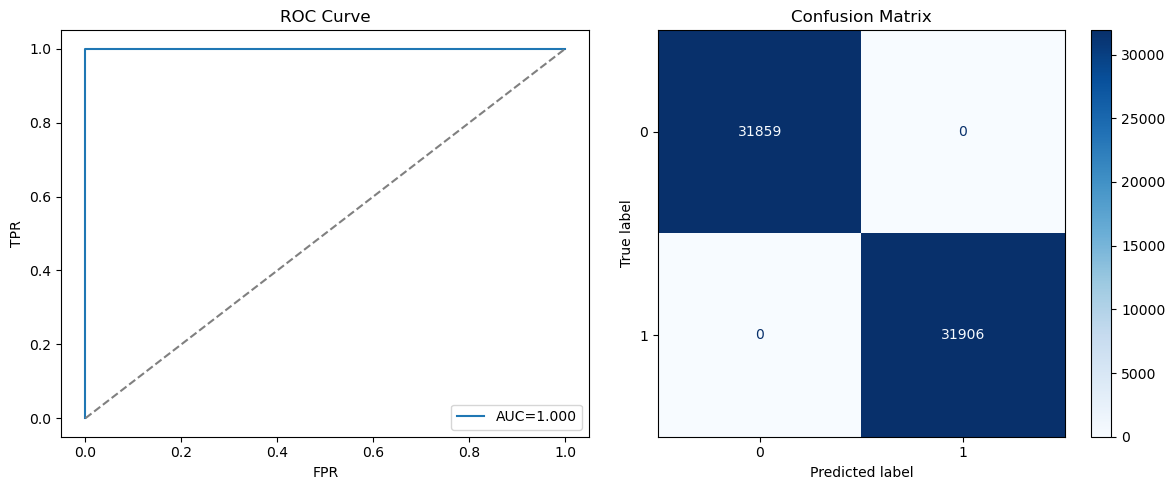

Saved diagnostics to: models\rf_diagnostics_1766088474.png


In [55]:

# Step 8: Save ROC plot and confusion matrix figure
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1,2, figsize=(12,5))

# ROC
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    ax[0].plot([0,1],[0,1], linestyle='--', color='gray')
    ax[0].set_title("ROC Curve")
    ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
    ax[0].legend()
else:
    ax[0].text(0.5,0.5,"No predict_proba available", ha='center')

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[1], cmap='Blues')
ax[1].set_title("Confusion Matrix")

plot_path = os.path.join("models", f"{best_name}_diagnostics_{ts}.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plt.show()
print("Saved diagnostics to:", plot_path)
# ...existing code...

In [56]:

# Step 9: Retrain on full available data for production use (if acceptable)
pipeline_prod = pipeline_template
pipeline_prod.set_params(**best_params)
pipeline_prod.fit(pd.concat([X_train, X_test], axis=0), pd.concat([y_train, y_test], axis=0))
prod_path = os.path.join("models", f"{best_name}_production_{ts}.pkl")
joblib.dump(pipeline_prod, prod_path)
print("Saved production-ready model to:", prod_path)

# quick smoke test on a few rows
sample = X_test.head(3)
print("Sample predictions:", pipeline_prod.predict(sample))
try:
    print("Sample probs:", pipeline_prod.predict_proba(sample)[:,1])
except Exception:
    pass

Saved production-ready model to: models\rf_production_1766088474.pkl
Sample predictions: [1 0 0]
Sample probs: [1. 0. 0.]


In [57]:
# install missing packages in the notebook environment
%pip install fastapi pydantic

# filepath: c:\Year 4\Quantum\Quantum_final_project\classical_ml\model_api.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib, pandas as pd
import os

# robust base dir (works both as module and in notebook)
base_dir = os.path.dirname(__file__) if "__file__" in globals() else os.getcwd()
# use the actual production model filename saved by the notebook
MODEL_PATH = os.path.join(base_dir, "models", "rf_production_1766081555.pkl")

class Item(BaseModel):
    data: dict

app = FastAPI()

# load model safely and warn if unavailable
_model = None
try:
    _model = joblib.load(MODEL_PATH)
except Exception as e:
    print(f"Warning: could not load model at {MODEL_PATH}: {e}")

@app.post("/predict")
def predict(item: Item):
    if _model is None:
        raise HTTPException(status_code=503, detail="Model not available")
    df = pd.DataFrame([item.data])
    # try to align feature columns if preprocessing named 'pre' exists
    try:
        pre = _model.named_steps.get('pre') if hasattr(_model, 'named_steps') else None
        if pre is not None:
            cols = pre.transformers_[0][2]
            df = df.reindex(columns=cols)
    except Exception:
        pass

    try:
        probs = _model.predict_proba(df)[:, 1].tolist()
    except Exception:
        probs = None
    preds = _model.predict(df).tolist()
    return {"predictions": preds, "probabilities": probs}

Note: you may need to restart the kernel to use updated packages.


In [58]:


# Inspect cheap vs expensive and model predictions
label_names = {0: "cheap", 1: "expensive"}

# confirm how target was defined
try:
    print("Target mapped: 1 => expensive (>= median), 0 => cheap (< median)")
    print("Median used:", median_price)
except NameError:
    print("median_price not in scope; target column still uses median-based split")

# get predict_proba if available and raw preds
y_pred = pipeline_final.predict(X_test)
try:
    y_proba = pipeline_final.predict_proba(X_test)[:, 1]
except Exception:
    y_proba = None

# assemble results DataFrame
res = X_test.copy().reset_index(drop=True)
res["y_true"] = y_test.reset_index(drop=True)
res["y_pred"] = y_pred
if y_proba is not None:
    res["p_expensive"] = y_proba

# map to readable labels
res["true_label"] = res["y_true"].map(label_names)
res["pred_label"] = res["y_pred"].map(label_names)

# summary counts
print("\nTrue label counts:\n", res["true_label"].value_counts())
print("\nPredicted label counts:\n", res["pred_label"].value_counts())

# classification report with readable names
print("\nClassification report:")
print(classification_report(res["y_true"], res["y_pred"], target_names=["cheap","expensive"]))

# show top confident predictions for 'expensive' and 'cheap' (if probabilities available)
if "p_expensive" in res.columns:
    print("\nTop 5 most confident EXPENSIVE predictions:")
    display(res.sort_values("p_expensive", ascending=False).head(5)[list(X_test.columns)+["p_expensive","true_label","pred_label"]])

    print("\nTop 5 most confident CHEAP predictions:")
    display(res.sort_values("p_expensive", ascending=True).head(5)[list(X_test.columns)+["p_expensive","true_label","pred_label"]])
else:
    print("\nNo predict_proba available — use y_pred to inspect examples:")
    display(res.head(5))

# use custom threshold if you want to be more/less conservative (default threshold = 0.5)
if "p_expensive" in res.columns:
    thr = 0.6
    res["pred_by_thr"] = (res["p_expensive"] >= thr).astype(int)
    res["pred_by_thr_label"] = res["pred_by_thr"].map(label_names)
    print(f"\nCounts using threshold {thr}:")
    print(res["pred_by_thr_label"].value_counts())
    print("\nConfusion matrix (thresholded):")
    print(confusion_matrix(res["y_true"], res["pred_by_thr"]))


Target mapped: 1 => expensive (>= median), 0 => cheap (< median)
Median used: 294.0

True label counts:
 true_label
expensive    31906
cheap        31859
Name: count, dtype: int64

Predicted label counts:
 pred_label
expensive    31906
cheap        31859
Name: count, dtype: int64

Classification report:
              precision    recall  f1-score   support

       cheap       1.00      1.00      1.00     31859
   expensive       1.00      1.00      1.00     31906

    accuracy                           1.00     63765
   macro avg       1.00      1.00      1.00     63765
weighted avg       1.00      1.00      1.00     63765


Top 5 most confident EXPENSIVE predictions:


,log_price,price,square,price_per_sqm,dom,communityaverage,renovationcondition,ladderratio,followers,elevator,p_expensive,true_label,pred_label
0,6.309918,54241.0,101.40,5.424063,6.0,79654.0,4,0.250,2,1.0,1.0,expensive,expensive
35454,6.214608,96712.0,51.70,9.671180,34.0,89350.0,4,0.182,25,1.0,1.0,expensive,expensive
35465,5.726848,65894.0,46.59,6.589397,6.0,68665.0,1,0.250,6,1.0,1.0,expensive,expensive
35468,5.733341,34338.0,89.99,3.433715,21.0,31485.0,2,0.500,40,1.0,1.0,expensive,expensive
35469,6.029483,57918.0,71.74,5.791748,18.0,49956.0,1,0.500,35,0.0,1.0,expensive,expensive



Top 5 most confident CHEAP predictions:


,log_price,price,square,price_per_sqm,dom,communityaverage,renovationcondition,ladderratio,followers,elevator,p_expensive,true_label,pred_label
21310,5.594711,32607.0,82.50,3.260606,6.0,59224.0,1,0.333,0,0.0,0.0,cheap,cheap
26293,5.361292,30670.0,69.45,3.066955,6.0,61727.0,4,0.211,5,1.0,0.0,cheap,cheap
26290,5.407172,24590.0,90.69,2.458926,1.0,49350.0,4,0.500,4,0.0,0.0,cheap,cheap
26289,5.043425,23121.0,67.04,2.312053,1.0,45307.0,4,0.500,5,0.0,0.0,cheap,cheap
50666,5.429346,32797.0,69.52,3.279632,1.0,48527.0,4,0.500,47,0.0,0.0,cheap,cheap



Counts using threshold 0.6:
pred_by_thr_label
expensive    31906
cheap        31859
Name: count, dtype: int64

Confusion matrix (thresholded):
[[31859     0]
 [    0 31906]]


In [59]:
# get sizes, accuracy and confusion matrix
import os, json

# original dataset size
print("Original dataset (rows, cols):", df.shape if 'df' in globals() else "df not in scope")

# sampled training subset size (or full train if no subsample)
if 'X_train_sub' in globals():
    print("Sampled training subset (rows, cols):", X_train_sub.shape)
elif 'X_train' in globals():
    print("Training set (rows, cols):", X_train.shape, "(no subsample used)")
else:
    print("X_train not in scope")

# final model metrics (if available in memory)
if 'metrics' in globals():
    print("Final model accuracy:", metrics.get("accuracy"))
    print("Final model confusion_matrix:", metrics.get("confusion_matrix"))
# otherwise try grid search summary saved to disk
elif os.path.exists("models/grid_search_results.json"):
    with open("models/grid_search_results.json") as f:
        gs = json.load(f)
    for name, info in gs.items():
        print(f"{name}: test_accuracy={info.get('test_accuracy')}, confusion_matrix={info.get('confusion_matrix')}")
else:
    print("No metrics found in memory or models/grid_search_results.json")

Original dataset (rows, cols): (318825, 51)
Sampled training subset (rows, cols): (1000, 10)
Final model accuracy: 1.0
Final model confusion_matrix: [[31859, 0], [0, 31906]]
